In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import digamma
from sklearn.gaussian_process import GaussianProcessRegressor
import gpytorch

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

/Users/menang/anaconda3/envs/py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's consider a simpler setting where 
$f(x) = 4 sin(x), x \in [a,b]$, and $y_i$ is bags of each bin with 1/n width. So that $g(y) = E[sin(x)|y] = \frac{1}{max(y) - min(y)}\int_{min(y)}^{max(y)} 4 sin(x) dx = - 4 cos(max(y)) + 4 cos(min(y))$.

In [2]:
def func(x):
    return 4 * np.sin(x)

def ytox(y, a, b, n):
    xs = []
    for i in y:
        # Determine the bin index
        # Calculate bin width
        bin_width = (b - a) / n

        # Determine the bin index
        bin_index = int((i - a) // bin_width)

        # Calculate the lower and upper bounds of the detected bin
        lower_bound = a + bin_index * bin_width
        upper_bound = a + (bin_index + 1) * bin_width
        
        x = np.random.uniform(lower_bound, upper_bound)
        xs.append(x)
        
    return np.array(xs) 

def g(y, a=-4, b=4, n=20, sigma=0.1):
    # Calculate the bin width
   
    # Determine the bin index
    # Calculate bin width
    bin_width = (b - a) / n

    # Determine the bin index
    bin_index = int((y - a) // bin_width)

    # Calculate the lower and upper bounds of the detected bin
    lower_bound = a + bin_index * bin_width
    upper_bound = a + (bin_index + 1) * bin_width

    result = 1.0/(upper_bound - lower_bound) * (- 4 * np.cos(upper_bound) + 4 * np.cos(lower_bound)) + np.random.normal(0, sigma)
        
    return result

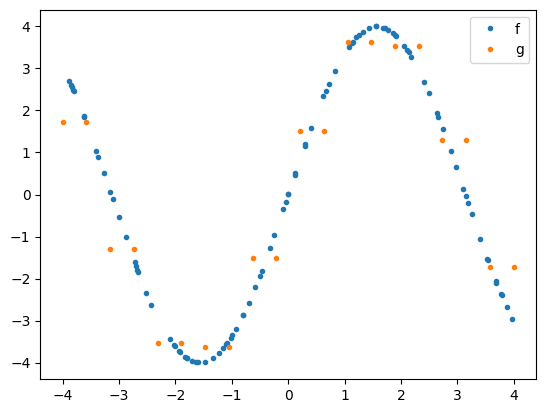

In [3]:
a = -4
b = 4
n = 10
sigma = 0

ys = np.linspace(a,b,100)
xs = ytox(ys, a, b, n)
fs = func(xs)
ys2 = np.linspace(a,b,20)
zs = np.array([g(y, a, b, n, sigma) for y in ys2])
plt.plot(xs, fs, '.', label= 'f')
plt.plot(ys2, zs, '.', label= 'g')
plt.legend()

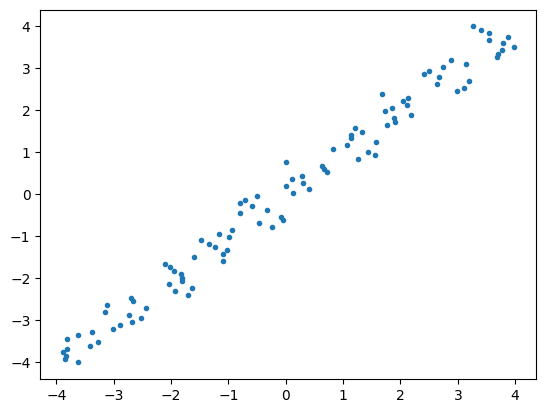

In [4]:
plt.plot(xs, ys, '.')

In [5]:
# muz, sigmaz = zs.mean(), zs.std()
# zs = (zs - muz) / sigmaz
muz, sigmaz = 0, 1 # no normalisation

print('muz: ', muz)
print('sigmaz: ', sigmaz)

muz:  0
sigmaz:  1


In [6]:
import sys
# sys.path.append("../deconditional-downscaling/")
sys.path.append("experiments/swiss_roll/")
from models import build_model, train_model, predict 
import yaml 
import torch

cdf_dir = 'experiments/swiss_roll/config/exact_cmp.yaml' 
# cdf_dir = 'exact_cmp.yaml' 

with open(cdf_dir, "r") as f:
    cfg = yaml.safe_load(f)

cfg['model'].update(individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys2))
model = build_model(cfg['model'])

In [7]:
groundtruth_individuals = torch.tensor(np.linspace(a,b,100)).float()

cfg['training'].update(model=model,
                    individuals=torch.tensor(xs).float(),
                    extended_bags_values=torch.tensor(ys).float(),
                    bags_values=torch.tensor(ys2).float(),
                    aggregate_targets=torch.tensor(zs).float(),
                    bags_sizes=len(ys2),
                    groundtruth_individuals=groundtruth_individuals,
                    groundtruth_bags_sizes=len(groundtruth_individuals),
                    groundtruth_targets=func(groundtruth_individuals).float(),
                    chunk_size=cfg['evaluation']['chunk_size_nll'],
                    device_idx='cpu',
                    dump_dir='result/'
                    )
train_model(cfg['training'])

In [8]:
predict_kwargs = {'name': cfg['model']['name'],
                'model': model.eval().cpu(),
                'individuals': groundtruth_individuals,
                'bags_sizes': func(groundtruth_individuals)}
individuals_posterior = predict(predict_kwargs)
individuals_posterior_mean = sigmaz * individuals_posterior.mean + muz
# individuals_posterior_mean = individuals_posterior.mean
with torch.no_grad():
    stddev = sigmaz * individuals_posterior.stddev
    # stddev = individuals_posterior.stddev
    lower_bound = individuals_posterior_mean - 2 * stddev
    upper_bound = individuals_posterior_mean + 2 * stddev

In [9]:
individuals_posterior.sample()

tensor([ 3.3435,  3.0616,  2.7498,  2.4264,  2.0820,  1.6960,  1.3073,  0.9297,
         0.5026,  0.0827, -0.3195, -0.7459, -1.1459, -1.5481, -1.9243, -2.2881,
        -2.6361, -2.9381, -3.2149, -3.4431, -3.6266, -3.7835, -3.8394, -3.8683,
        -3.8797, -3.8144, -3.7427, -3.6339, -3.5122, -3.3762, -3.2473, -3.1824,
        -3.0944, -3.0584, -3.0395, -3.0841, -3.1353, -3.1967, -3.2933, -3.3664,
        -3.4495, -3.4566, -3.4450, -3.3820, -3.2231, -2.9937, -2.6988, -2.3026,
        -1.8452, -1.3343, -0.7314, -0.1590,  0.4485,  1.0733,  1.6511,  2.1991,
         2.7067,  3.1737,  3.5530,  3.8893,  4.1808,  4.4009,  4.5924,  4.6988,
         4.7712,  4.8211,  4.8135,  4.8031,  4.7363,  4.6424,  4.5067,  4.3388,
         4.1377,  3.8900,  3.6444,  3.3293,  2.9872,  2.6286,  2.2637,  1.8733,
         1.5045,  1.1362,  0.7874,  0.4709,  0.2127, -0.0262, -0.1977, -0.3485,
        -0.4885, -0.5781, -0.6656, -0.7481, -0.8224, -0.9059, -0.9933, -1.1491,
        -1.2768, -1.4357, -1.5953, -1.72

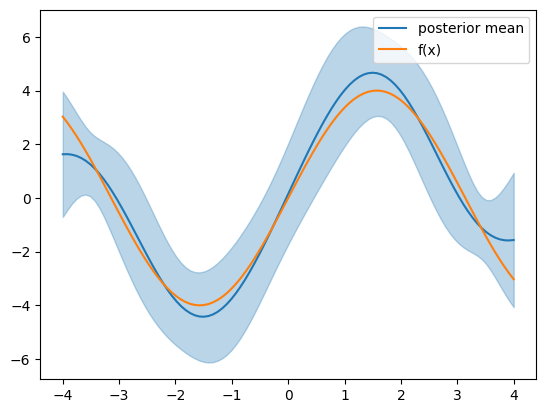

In [10]:
plt.plot(groundtruth_individuals, individuals_posterior_mean, label = 'posterior mean', color='C0')
plt.fill_between(groundtruth_individuals, lower_bound, upper_bound, alpha=0.3, color='C0')
# plt.plot(groundtruth_individuals, (conf[1]-conf[0]).detach().numpy(), label = '2 * posterior std')
plt.plot(groundtruth_individuals, func(groundtruth_individuals), label = 'f(x)', color='C1')
# plt.plot(xs, f(xs), '.', label = 'data points')
plt.legend()

In [11]:
groundtruth_individuals[np.argmin(func(groundtruth_individuals))]

tensor(-1.5758)

In [12]:
groundtruth_individuals[np.argmin(individuals_posterior_mean)]

tensor(-1.4949)

In [13]:
from BO import BayesOpt_UCB, BayesOpt_Random, PES, MES

x_space = torch.tensor(np.linspace(a,b,100)).float() # np.linspace(1e-5,1-1e-5,100)
y_space = torch.tensor(np.linspace(a,b,100)).float() # np.linspace(1e-5,1-1e-5,100)
init_y_size = 10
num_round = 20
num_repeat = 10
random_seeds = np.random.uniform(0,100, num_repeat)

pos_best_dict = {}
z_rewards_dict = {}

xs = torch.from_numpy(xs).float()
ys = torch.from_numpy(ys).float()

In [14]:
# agent_ucb = BayesOpt_UCB(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp.yaml', dump_dir='result/ucb/', random_seeds=random_seeds)
# pos_best_dict['ucb'] = agent_ucb.simulation()

In [ ]:
num_repeat = 5
agent_mes = MES(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp.yaml', dump_dir='result/mes/', random_seeds=random_seeds)
pos_best_mes, z_rewards_mes = agent_mes.simulation()
pos_best_dict['mes'] = pos_best_mes
z_rewards_dict['mes'] = z_rewards_mes

  0%|          | 0/5 [00:00<?, ?it/s]

[-3.9191918   0.8484849  -2.868687    3.838384    0.04040404 -2.5454545
  3.030303   -3.5959597  -2.6262627   1.4949495 ]


Iteration 1: Elapsed Time: 3.094996929168701 seconds


Iteration 2: Elapsed Time: 2.939088821411133 seconds


Iteration 3: Elapsed Time: 2.9577760696411133 seconds


Iteration 4: Elapsed Time: 2.9844350814819336 seconds


Iteration 5: Elapsed Time: 3.040405035018921 seconds


Iteration 6: Elapsed Time: 2.9551732540130615 seconds


Iteration 7: Elapsed Time: 3.133762836456299 seconds


Iteration 8: Elapsed Time: 2.9543380737304688 seconds


Iteration 9: Elapsed Time: 3.0750153064727783 seconds


 20%|██        | 1/5 [00:30<02:01, 30.28s/it]

Iteration 10: Elapsed Time: 3.131469964981079 seconds
[-3.1111112  -1.979798   -2.4646466   3.5959597  -0.9292929  -3.191919
  3.6767676  -2.1414142  -0.36363637  3.4343433 ]


Iteration 1: Elapsed Time: 2.9372541904449463 seconds


Iteration 2: Elapsed Time: 3.02532696723938 seconds


Iteration 3: Elapsed Time: 2.977569103240967 seconds


Iteration 4: Elapsed Time: 3.098886251449585 seconds


Iteration 5: Elapsed Time: 3.028756856918335 seconds


Iteration 6: Elapsed Time: 3.0533859729766846 seconds


Iteration 7: Elapsed Time: 3.0879311561584473 seconds


Iteration 8: Elapsed Time: 3.0075316429138184 seconds


Iteration 9: Elapsed Time: 3.011002779006958 seconds


 40%|████      | 2/5 [01:00<01:30, 30.31s/it]

Iteration 10: Elapsed Time: 3.0980169773101807 seconds
[-0.12121212 -0.6060606  -1.6565657  -2.3030303  -0.04040404  1.8989899
  3.1111112  -1.0909091   1.6565657  -1.1717172 ]


Iteration 1: Elapsed Time: 3.039252996444702 seconds


Iteration 2: Elapsed Time: 2.993557929992676 seconds


Iteration 3: Elapsed Time: 3.103039264678955 seconds


Iteration 4: Elapsed Time: 3.0724189281463623 seconds


Iteration 5: Elapsed Time: 3.083113193511963 seconds


Iteration 6: Elapsed Time: 3.0168468952178955 seconds


Iteration 7: Elapsed Time: 3.175014019012451 seconds


Iteration 8: Elapsed Time: 3.094743013381958 seconds


Iteration 9: Elapsed Time: 3.1510660648345947 seconds


 60%|██████    | 3/5 [01:31<01:01, 30.57s/it]

Iteration 10: Elapsed Time: 3.126736879348755 seconds
[ 3.3535354  -0.04040404  1.979798   -2.1414142  -1.8181819  -2.3030303
 -2.060606    2.868687    3.030303   -3.1111112 ]


Iteration 1: Elapsed Time: 3.055584192276001 seconds


Iteration 2: Elapsed Time: 3.069920063018799 seconds


Iteration 3: Elapsed Time: 3.157766819000244 seconds


Iteration 4: Elapsed Time: 3.0397510528564453 seconds


Iteration 5: Elapsed Time: 3.1287879943847656 seconds


Iteration 6: Elapsed Time: 3.2204859256744385 seconds


Iteration 7: Elapsed Time: 3.7033541202545166 seconds


Iteration 8: Elapsed Time: 3.1040568351745605 seconds


Iteration 9: Elapsed Time: 2.9932050704956055 seconds


 80%|████████  | 4/5 [02:03<00:30, 30.99s/it]

Iteration 10: Elapsed Time: 3.1530370712280273 seconds
[-2.868687   3.6767676 -2.7070706  1.5757576  2.1414142  3.3535354
 -2.2222223 -1.7373737  2.5454545  0.7676768]


Iteration 1: Elapsed Time: 3.1829230785369873 seconds


Iteration 2: Elapsed Time: 3.2413530349731445 seconds


Iteration 3: Elapsed Time: 3.127858877182007 seconds


Iteration 4: Elapsed Time: 3.116176128387451 seconds


Iteration 5: Elapsed Time: 3.066977024078369 seconds


Iteration 6: Elapsed Time: 3.182201862335205 seconds


Iteration 7: Elapsed Time: 3.056577205657959 seconds


Iteration 8: Elapsed Time: 3.1601598262786865 seconds


Iteration 9: Elapsed Time: 3.178576946258545 seconds


100%|██████████| 5/5 [02:34<00:00, 30.91s/it]

Iteration 10: Elapsed Time: 3.1201860904693604 seconds


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
# agent_pes = PES(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp.yaml', dump_dir='result/pes/',  y_min=-3, λ=0.01, num_opt_samples=10, random_seeds=random_seeds)
# pos_best_dict['pes'] = agent_pes.simulation()

(array([1., 2., 3., 0., 0., 1., 1., 8., 2., 2.]),
 array([-3.91919184, -3.15959597, -2.39999986, -1.64040399, -0.88080806,
        -0.12121212,  0.63838381,  1.39797974,  2.15757561,  2.91717172,
         3.67676759]),
 <BarContainer object of 10 artists>)

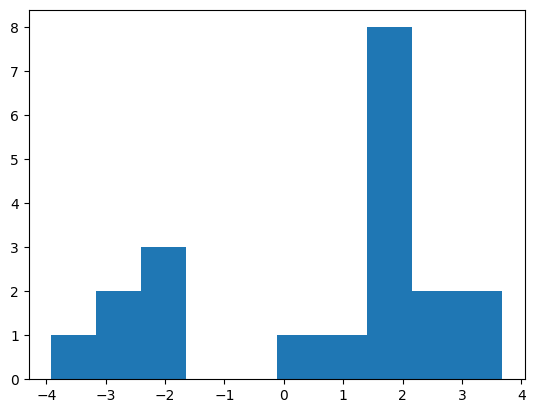

In [17]:
plt.hist(agent_mes.y_recs)

In [18]:
# agent_ucb = BayesOpt_UCB(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g_oracle,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp_mz.yaml', dump_dir='result/ucb/', random_seeds=random_seeds)
# pos_best_dict['ucb'] = agent_ucb.simulation()

In [19]:
agent_random = BayesOpt_Random(dataset1=[xs, ys], init_y_recs_size = init_y_size, y_space=y_space, x_space=x_space, f_oracle=func, g_oracle=g,num_round=num_round, num_repeat = num_repeat, cdf_dir='experiments/swiss_roll/config/exact_cmp.yaml', dump_dir='result/random/', random_seeds=random_seeds)
pos_best_random, z_rewards_random = agent_random.simulation()
pos_best_dict['random'] = pos_best_random
z_rewards_dict['random'] = z_rewards_random

  0%|          | 0/5 [00:00<?, ?it/s]

[-3.9191918   0.8484849  -2.868687    3.838384    0.04040404 -2.5454545
  3.030303   -3.5959597  -2.6262627   1.4949495 ]


Iteration 1: Elapsed Time: 3.0108251571655273 seconds


Iteration 2: Elapsed Time: 3.2190282344818115 seconds


Iteration 3: Elapsed Time: 3.179847002029419 seconds


Iteration 4: Elapsed Time: 3.1684961318969727 seconds


Iteration 5: Elapsed Time: 3.3791677951812744 seconds


Iteration 6: Elapsed Time: 3.184454917907715 seconds


Iteration 7: Elapsed Time: 3.208235740661621 seconds


Iteration 8: Elapsed Time: 3.371917724609375 seconds


Iteration 9: Elapsed Time: 3.0405397415161133 seconds


 20%|██        | 1/5 [00:31<02:07, 31.86s/it]

Iteration 10: Elapsed Time: 3.086038827896118 seconds
[-3.1111112  -1.979798   -2.4646466   3.5959597  -0.9292929  -3.191919
  3.6767676  -2.1414142  -0.36363637  3.4343433 ]


Iteration 1: Elapsed Time: 2.987077236175537 seconds


Iteration 2: Elapsed Time: 3.0727710723876953 seconds


Iteration 3: Elapsed Time: 3.049420118331909 seconds


Iteration 4: Elapsed Time: 2.987755060195923 seconds


Iteration 5: Elapsed Time: 3.206914186477661 seconds


Iteration 6: Elapsed Time: 3.1595089435577393 seconds


Iteration 7: Elapsed Time: 3.115165948867798 seconds


Iteration 8: Elapsed Time: 3.0229809284210205 seconds


Iteration 9: Elapsed Time: 3.055805206298828 seconds


 40%|████      | 2/5 [01:02<01:33, 31.12s/it]

Iteration 10: Elapsed Time: 2.9275779724121094 seconds
[-0.12121212 -0.6060606  -1.6565657  -2.3030303  -0.04040404  1.8989899
  3.1111112  -1.0909091   1.6565657  -1.1717172 ]


Iteration 1: Elapsed Time: 3.0900039672851562 seconds


Iteration 2: Elapsed Time: 2.9430999755859375 seconds


Iteration 3: Elapsed Time: 3.0952131748199463 seconds


Iteration 4: Elapsed Time: 3.06005597114563 seconds


Iteration 5: Elapsed Time: 3.0363590717315674 seconds


Iteration 6: Elapsed Time: 3.671886920928955 seconds


Iteration 7: Elapsed Time: 2.954871892929077 seconds


Iteration 8: Elapsed Time: 3.09420108795166 seconds


Iteration 9: Elapsed Time: 3.301506996154785 seconds


 60%|██████    | 3/5 [01:34<01:02, 31.34s/it]

Iteration 10: Elapsed Time: 3.349043846130371 seconds
[ 3.3535354  -0.04040404  1.979798   -2.1414142  -1.8181819  -2.3030303
 -2.060606    2.868687    3.030303   -3.1111112 ]


Iteration 1: Elapsed Time: 3.6946911811828613 seconds


Iteration 2: Elapsed Time: 3.1955509185791016 seconds


Iteration 3: Elapsed Time: 3.318037986755371 seconds


Iteration 4: Elapsed Time: 3.5774178504943848 seconds


Iteration 5: Elapsed Time: 3.215669870376587 seconds


Iteration 6: Elapsed Time: 3.0787458419799805 seconds


Iteration 7: Elapsed Time: 3.396165132522583 seconds


Iteration 8: Elapsed Time: 3.2626020908355713 seconds


Iteration 9: Elapsed Time: 3.370893955230713 seconds


 80%|████████  | 4/5 [02:07<00:32, 32.08s/it]

Iteration 10: Elapsed Time: 3.0802109241485596 seconds
[-2.868687   3.6767676 -2.7070706  1.5757576  2.1414142  3.3535354
 -2.2222223 -1.7373737  2.5454545  0.7676768]


Iteration 1: Elapsed Time: 3.399522066116333 seconds


Iteration 2: Elapsed Time: 3.132774829864502 seconds


Iteration 3: Elapsed Time: 3.0893962383270264 seconds


Iteration 4: Elapsed Time: 3.0700557231903076 seconds


Iteration 5: Elapsed Time: 3.1159520149230957 seconds


Iteration 6: Elapsed Time: 3.1497480869293213 seconds


Iteration 7: Elapsed Time: 3.224508047103882 seconds


Iteration 8: Elapsed Time: 3.109139919281006 seconds


Iteration 9: Elapsed Time: 2.9640872478485107 seconds


100%|██████████| 5/5 [02:38<00:00, 31.73s/it]

Iteration 10: Elapsed Time: 3.1134867668151855 seconds


In [20]:
def evalaution(pos_best_dict):
    # plt.plot(range(self.n), self.z_rewards[self.init_y_recs_size:], '.', label = 'z rewards')
    for name, pos_bests in pos_best_dict.items():
        opt = np.max(func(x_space.numpy()))
        regret_mean =np.abs(opt - pos_bests).mean(axis=0)
        regret_std =np.abs(opt - pos_bests).std(axis=0)
        # print(regret_mean)
        plt.plot(range(len(regret_mean)), regret_mean, label = name)
        plt.fill_between(range(len(regret_mean)), regret_mean - 2 * regret_std, regret_mean + 2 * regret_std, alpha = 0.3)
    # plt.ylim(0,3)
    plt.legend()
    plt.xlabel('Round')
    plt.ylabel('Regret')  

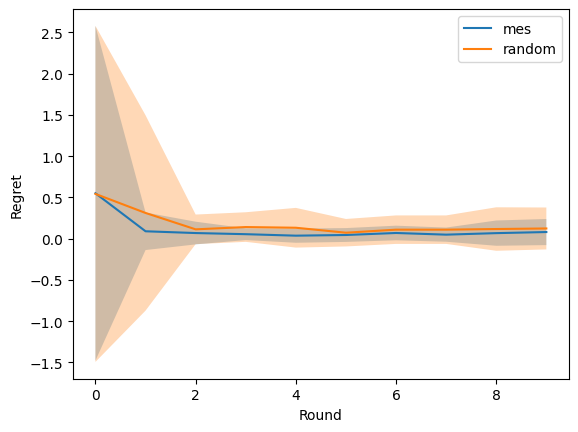

In [21]:
evalaution(pos_best_dict)

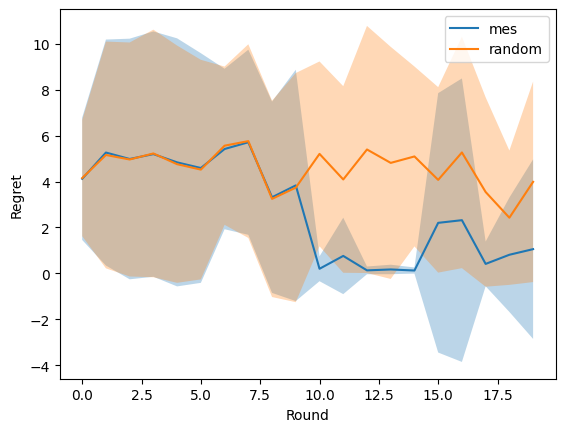

In [22]:
evalaution(z_rewards_dict)